In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

np.random.seed(42)

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark") 

### Hidden Markov Model for Modelling high and low Volatility Regimes 
------

We will apply Hidden Markov Modelling technique to infer the hidden states as high and low volatility of a stock return time series. This method can be also applied to multi-variate time series with a non-diagonal covariance matrix that describes the correlation between different stock returns. 

<div>
<img src= "HMM.png" width="720"/>
</div> 

The hidden Markov model (HMM) is a powerful probabilistic model of sequential data. The key idea is that a latent variable or state variable $z$ rather than the data, evolves according to a discrete, first-order Markov process. Each observation $x$ is conditionally independent of every other observation given the value of its associated latent (hidden) variable. Note that here $n-1$, $n$ and $n+1$ denote the time component of the observations and the hidden states. 

**Markov Assumption of hidden states:**

We assume the latent variables follow a random process, a K-state Markov chain. Therefore for any $n$ we have 

$$ p(z_{n+1} | z_n, z_{n-1},\dots,z_1) = p(z_{n+1} | z_n) .$$

For example, consider a `K=2` state Markov chain modeling the volatility. It can either be High volatility ($z_n=s$) or low ($z_n =r$) at time index $n$ (day, hour, minute, etc.):


<div>
<img src= "HS.png" width="720"/>
</div> 


The chain diagram above gives us one of the important parameters of a HMM, namely the transition probabilities: 



$$ p(s|r) =p, \quad p(r|r) = 1-p, \quad\textrm{and}\quad p(r | s) = q, \quad p(s|s) = 1-q $$

In the context of stock returns, we know what we want to model, we want to distinguish between high volitility and low volatility regimes (states) of stock returns which as we know arise due to volatility clustering which implies a long periods of low volatility and shorter periods of high volatility:

$$\textrm{E.g}: 1-p = 0.95, \quad p = 0.05 \quad\textrm{and}\quad 1-q = 70, \quad q = 0.3$$

For a generic number of states: $z(t) \in \{1,2,\dots,K\}$, this logic gives us the $K\times K$ **transition probability matrix:**

$$ p(z_{n+1} = j | z_n = i) \equiv A_{ij}, \quad\textrm{for}\quad \forall n . $$

A further assumption here is that Markov process is **stationary** or **time-homogeneous**. This assumption can be changed to produce a time-inhomogeneous Markov chain, but we’ll focus on the time-homogeneous model.

Along with the transition probability matrix, in HMM we have **observation/emission probabilities**  which model how we assume our data are distributed given the state variable: 

$$ p(x_n | z_n = i, \phi_i), $$

where $\phi_i$ are the parameters of some distribution which we posit. For example, we can model $x_n$ as a D-variate normal given $z_n$ (assuming we have a multi-variate time series, for univariate time series $D = 1$):

$$ x_n \sim \mathcal{N}(x_n | \mu_i, \Sigma_i) .$$

Thus $z_n$ indexes the parameters of the distribution, meaning it specifies which parameters to use in the set $\{\phi_i\}_{i=1}^K$ at time $n$. 

Question: For the stock returns example we would like to focus, does it make sense to sample from a Gaussian for each high and low volatility state? 

Answer: Recall from the Gaussian Mixture Models (GMM) that by sampling from two different Gaussians with different volatilities can result with a fat tailed, skinny shouldered distribution as for the stock returns. 

In our example, we will work with a univariate time series of stock returns to label them as high and low volitility so that at a given time $n$ will be 

$$ x_n \sim \mathcal{N}(x_n | \mu_{L/H}, \sigma_{L,H}) .$$



#### HMM Tasks
-----

We can use HMM for 3 important tasks: 

1. Task 1: Finding p(x)

- let's denote the sequence of observations ${\bf x} = \{x_1, x_2, \dots, x_T\}$ and start with the simplest one node model $T = 1$: 

    - We have $p(z_1)$: prior distribution of the markov chain and $p (x_1 | z_1)$. In graphical models like HMM, we are typically insterested in the joint distribution: 

    $$ p(x_1, z_1) = p(x_1 | z_1) p(z_1) $$

    - However the main probability distribution we are interested in is $p(x_1)$ which can be found by marginalizing over the hidden state $z_1$: 

    $$  p(x_1) = \sum_{i=1}^K p(x_1, z_1 = i)$$

- Generalizing to a sequence of length $T$ with ${\bf x} = \{x_1, x_2, \dots, x_T\}$ and hidden states ${\bf z} = \{z_1,z_2,\dots,z_T\}$:
    - The joint probability distribution is given by: 

    $$ p({\bf x}, {\bf z}) = p(z_1) p(x_1 | z_1) \prod_{t=2}^{T} p(z_t | z_{t-1}) p(x_t | z_t) $$

    - Then the main probability distribution of interest can be found by marginalizing over all the hidden states: 

    $$ p({\bf x}) = \sum_{z_1}\sum_{z_2}\dots \sum_{z_T} p({\bf x}, {\bf z}, \phi) $$

This process of finding $p({\bf x})$ is however problematic as it has computational complexity of $\mathcal{O}(T K^T)$: exponential complexity! Smart algorithms should be used for this process.

2. Task 2: Finding model parameters using $p({\bf x})$

    - We can find the model parameters $\phi$ by searching for the parameters that maximize the log likelihood of $p({\bf x})$: 

        - E.g using gradient ascent method: 

        $$\textrm{for}\quad \phi = \textrm{set of parameters} $$
        $$ \textrm{repeat:}\quad \phi \to \phi + \alpha \nabla \ln(p({\bf x}))$$

3. Task 3: Decoding (Inference)

- The graphical HMM model shows that hidden states $z$ points to the observations $x$: e.g they are the hidden cause of observations. 

- In reality, from the observations we made ${\bf x}$, we want to know ${\bf z}$

This decoding(inference) process returns the most likely sequence of ${\bf z}$ given a sequence of ${\bf x}$: The probability that we would like to maximize for this task is the posterior distribution: $p({\bf z}|{\bf x})$ .

$$ {\bf z}^{*} = \textrm{argmax}_{\bf z}\,\, p({\bf z}|{\bf x}) = \textrm{argmax}_{\bf z}\,\, \frac{p({\bf x}, {\bf z})}{p({\bf x})} \equiv \textrm{argmax}_{\bf z}\,\, p({\bf x}, {\bf z}) $$

Let's say that we want to find this sequence of ${\bf z}^{*}$ that maximizes $p({\bf x}, {\bf z})$

A Naive solution to this problem includes

- Generate all possible sequences of $z_1, z_2, \dots, z(T)$
- Loop through each one, return the one that yields maximum $p({\bf x}, {\bf z})$ 

This Naive solution however requires searching for $K^T$ sequences so that it has still exponential complexity. A more efficient solution is Viter decoding or Viterbi algorithm.  

One method that can be used for this purpose is `hmm` from the `hmmlearn` library using `GaussianHMM()` method:

`model = hmm.GaussianHMM()`

`model.fit(X) # to find A_{ij}, \mu, \sigma (or Covariance Matrix of a given state)`

`Z = hmm.predict(X) # inference using Viterbi Algorithm`






For more info refer to the [API](https://hmmlearn.readthedocs.io/en/latest/).

In [4]:
# Install hmmlearn

# !pip install hmmlearn

In [2]:
# import hmm from hmmlearn

from hmmlearn import hmm

In [3]:
df = pd.read_csv('SPY.csv', index_col = 0, parse_dates = True)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,92.246048,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.490204,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.555328,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.946060,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,93.255348,126402800


In [4]:
# log returns 

df_returns = np.log(df[['Close']].pct_change()+1).dropna()

df_returns.head()

,Close
Date,
2010-01-05,0.002644
2010-01-06,0.000704
2010-01-07,0.004212
2010-01-08,0.003322
2010-01-11,0.001396


Text(0.5, 1.0, 'Histogram of SPY returns')

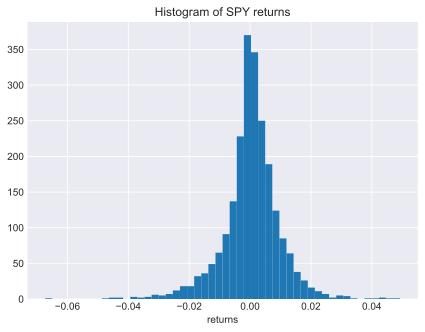

In [5]:
# histogram of returns to remind ourselves that it has tail tails and skinny shoulders unlike a Gaussian distribution

df_returns.hist(bins = 50, figsize = (7,5))

plt.xlabel('returns')
plt.title('Histogram of SPY returns')

In [6]:
# model 
# n_component = number of hidden states, since we know what to model: high and low volatility regimes it is 2
# for a single time series it is redundant to set covarinace_type, however for multiple one can also choose other
# options e.g "full", in some cases this can lead to singular covariance matrix 

model = hmm.GaussianHMM(n_components = 2, covariance_type= 'diag')

In [7]:
# reshape returns to N * 1 and fit 

X = df_returns.to_numpy().reshape(-1,1)

model.fit(X) # gives the parameters 

GaussianHMM(n_components=2)

In [26]:
# We are doing unsupervised learning so the states 0 and 1 have inherently no meaning 
# it is up to us to assing a meaning to these labels
# it is similar to clustering 

Z = model.predict(X)

Z

array([0, 0, 0, ..., 1, 0, 0])

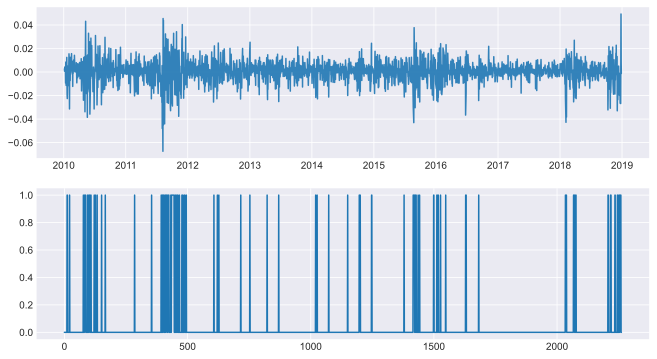

In [9]:
fig, axes = plt.subplots(2,1,figsize = (11,6))

axes[0].plot(df_returns, alpha = 0.9)
axes[1].plot(Z)

for i in range(2):
    axes[i].grid()


It seems that there is some kind of pattern. When we have large returns we tend to see clustered thicker lines of Z's. For low returns we see gaps in between. This is encouraging as the model seems to tell the difference between high volatility and low volatility regions. 

In [35]:
# model parameters, state 0 has positive mean return whereas state 1 has negative 

model.means_, model.covars_

(array([[ 0.00090123],
        [-0.00396093]]),
 array([[[5.19953590e-05]],
 
        [[4.34161781e-04]]]))

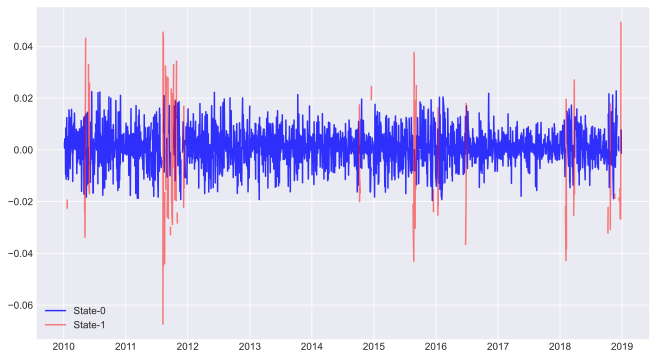

In [32]:
# lets color different segments to get more insight 

fig, axes = plt.subplots(figsize = (11,6))

returns0 = pd.DataFrame(index = df_returns.index)
returns1 = pd.DataFrame(index = df_returns.index)

returns0['S0'] = np.nan
returns1['S1'] = np.nan

returns0['S0'] = df_returns[Z == 0]
returns1['S1'] = df_returns[Z == 1]

axes.plot(returns0, c = 'blue',alpha = 0.8, label = 'State-0')
axes.plot(returns1, c = 'red', alpha = 0.5, label = 'State-1')

axes.grid()
axes.legend()


Red segments corresponds to high volatility regions. 
Notice however that the values do seem to jump around quite a lot. When we are in state 1 sometimes we do not stay in it for long enough of time. Does it makes sense to regime to change every day? We would probably not as this does not match with our expectations from the volatility clustering. 

What we can do? 

In [36]:
# state transition matrix 

model.transmat_

array([[0.91536284, 0.08463716],
       [0.65585184, 0.34414816]])

00 element above is the probability of staying in state 0. 01th element is the transition prob for 0 --> 1. 10th element is the prob for: 1 --> 0 while the 11th is 1 --> 1 transition. We see that while staying in the 0th state is persistent, staying on the 1st state is not that persistent. So to model the volatility clustering we can squeeze off diagonal elements towards 0 while the diagonal ones towards probability of 1. 

As the transition probility from 1 to 0 is high, this explains the reason why we have seen thick lines that jump between 1 and 0!!!

In [71]:
# generate a new instance of the model specifying the initializing parameters mean, covariance and s for start probability

model = hmm.GaussianHMM(n_components = 2, covariance_type= 'diag', init_params = 'mcs')

In [72]:
model.transmat_ = np.array([[0.999, 0.001],[0.001,0.999]])

In [73]:
model.fit(X)

GaussianHMM(init_params='mcs', n_components=2)

In [74]:
# and run the inference again 

Z = model.predict(X)

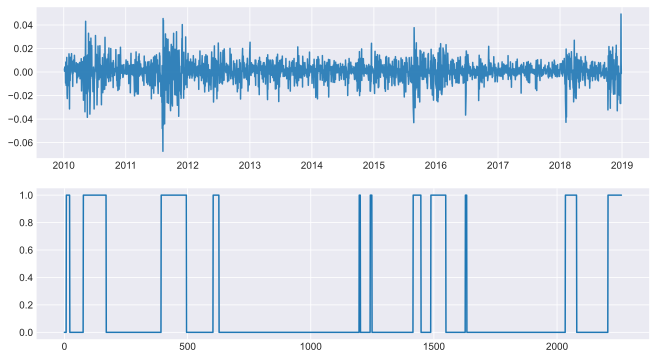

In [75]:
# plot again 

fig, axes = plt.subplots(2,1,figsize = (11,6))

axes[0].plot(df_returns, alpha = 0.9)
axes[1].plot(Z)

for i in range(2):
    axes[i].grid()

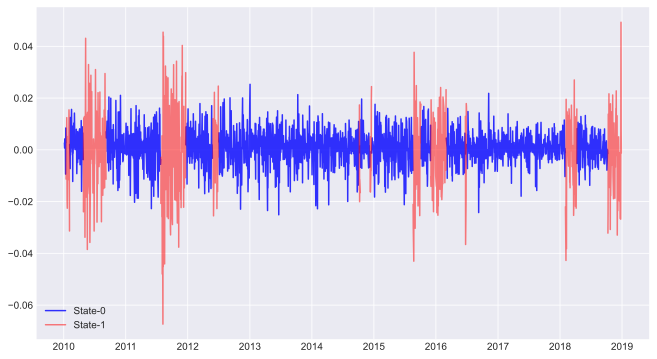

In [76]:
# lets color different segments to get more insight 

fig, axes = plt.subplots(figsize = (11,6))

returns0 = pd.DataFrame(index = df_returns.index)
returns1 = pd.DataFrame(index = df_returns.index)

returns0['S0'] = np.nan
returns1['S1'] = np.nan

returns0['S0'] = df_returns[Z == 0]
returns1['S1'] = df_returns[Z == 1]

axes.plot(returns0, c = 'blue',alpha = 0.8, label = 'State-0')
axes.plot(returns1, c = 'red', alpha = 0.5, label = 'State-1')

axes.grid()
axes.legend()

We see that highly volitile segments of the time series are more persistent as compared to earlier model. On the other hand, mean returns and volatility of each class is also different. 

In [79]:
model.means_

array([[ 0.00085562],
       [-0.00140285]])

In [80]:
model.covars_

array([[[4.58765286e-05]],

       [[2.73024267e-04]]])